### Import required libraries

In [2]:
import cv2
import glob
import numpy as np
from random import shuffle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

%matplotlib inline

### Read the car and non car images

In [3]:
car_images = glob.glob("vehicles/*/*.*")
noncar_images = glob.glob("non-vehicles/*/*.*")

# Shuffle the images 
shuffle(car_images)
shuffle(noncar_images)

# Print the length of the image data in each class
print(len(car_images), 'images for cars')
print(len(noncar_images), 'images of non-cars')

8792 images for cars
8968 images of non-cars


### Visualizing some sample car and non-car images

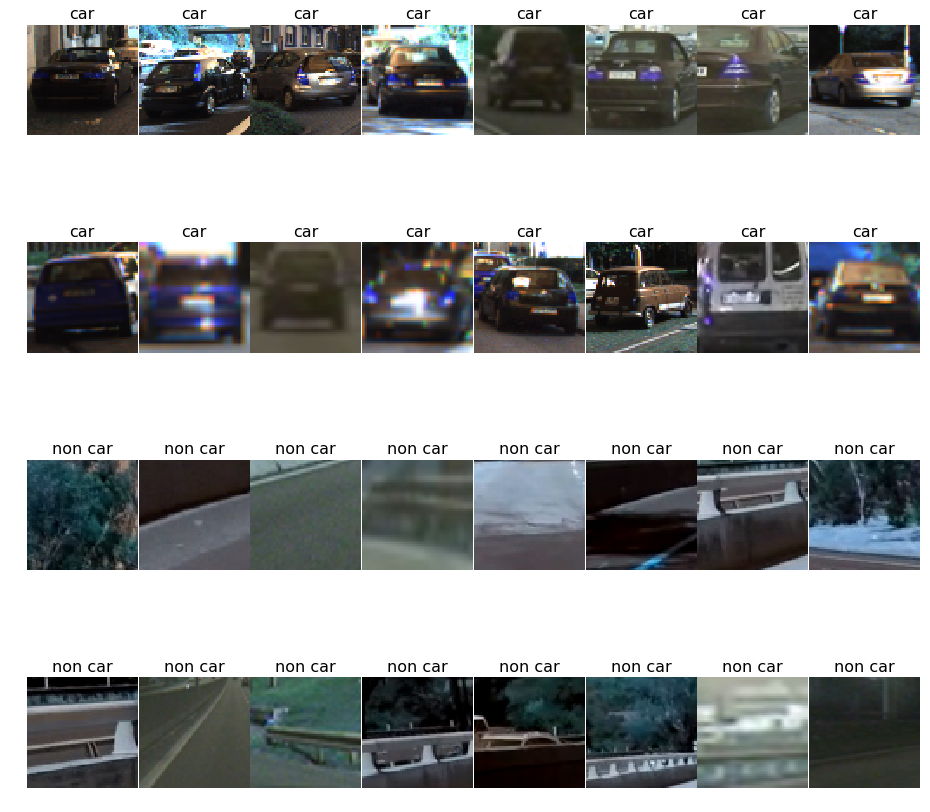

In [6]:
f, axs = plt.subplots(4,8,figsize = (16,16))
f.subplots_adjust(hspace = 0, wspace = 0.01)
axs = axs.ravel()

for i in range(16):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=16)
    axs[i].imshow(img)
    
for i in range(16,32):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    axs[i].axis('off')
    axs[i].set_title('non car', fontsize=16)
    axs[i].imshow(img)

### Convert Image to Histogram of Gradients (HOG)

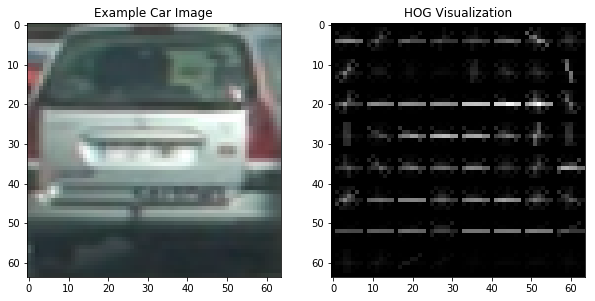

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Read in a random image and convert to grayscale
image = mpimg.imread(car_images[np.random.randint(0, len(car_images))])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# calling the get_hog function to return visualization and features
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_visualization.png', 
            bbox_inches="tight")

### Creating function for Color Histogram

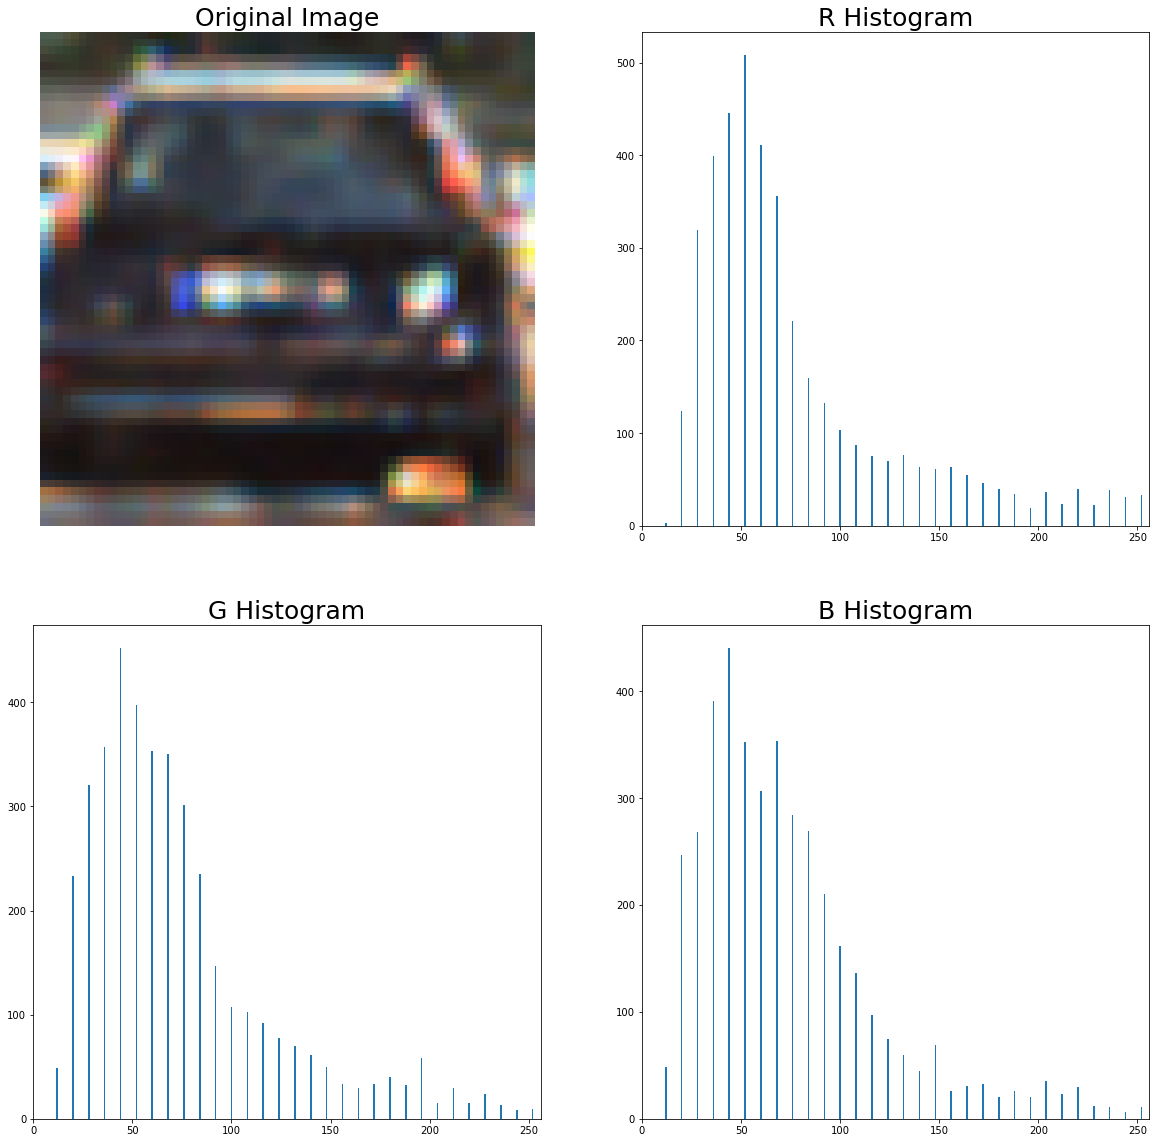

In [9]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

# Choose a random image and run the histogram on it (visualize the bins and frequencies)
img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(20,20));

plt.subplot(221)
plt.imshow(image)
plt.title('Original Image', fontsize=25)
plt.axis('off')
plt.subplot(222)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=25);
plt.subplot(223)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=25);
plt.subplot(224)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=25);


### Extract Color feature (Raw pixel data)

In [10]:
# A function that resizes an image and takes the raw pixel values as the feature
# This could be done in any given color space
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

### Extract combined feature vector (multiple images)

In [11]:
# Define a function that extracts features from the image and returns them as a feature vector
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        
        # Concatenate the spatial_bin, hist_colors and HOG features if requested
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Train classifier to categorize car and non car images (HOG + Spatial)

In [12]:
# Extract features using HOG and spatial features

car_features = extract_features(car_images, spatial_feat=True, hist_feat=True)
notcar_features = extract_features(noncar_images, spatial_feat=True, hist_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:29<00:00, 300.13it/s]


19.72 seconds to train SVC.
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


### Test accuracy of model using feature vector (HOG + Spatial)

In [13]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC: 96.99%

  Predictions: [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
       Labels: [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]

0.01197 seconds to predict 10 labels with SVC.


### Sliding Window Code (Applied to single image)

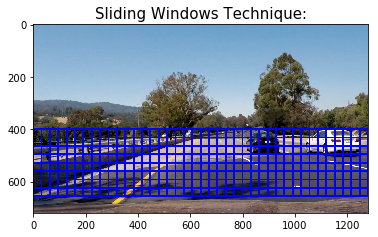

In [14]:
# Implementing the Sliding window method on a sample image
# This function only runs through the specified region of an image - 
# This does not do the classification 
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (0,0,255)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:', fontsize=15);
plt.savefig('output_images/sliding_windows.png', bbox_inches="tight")

### Extract features from a single image

In [15]:
# This function basically allows us to pass the window region and get the required 
# feature vector to check if it is a car or not 

def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Run the single feature extract on windows and return

In [16]:
# This function uses the single image feature vector to predict if the 
# area covered by a window is a car or not 
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Training the model with different color space (spatial + HOG + hist_color) 

In [22]:
color_space = 'YCrCb' 
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)

100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:41<00:00, 217.68it/s]


In [23]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
# Check the prediction time for a single sample
t=time.time()

Using: 10 orientations, 8 pixels per cell and 2 cells per block
Feature vector length: 9144
8.18 Seconds to train SVC...
Test Accuracy of SVC = 98.59%


#### We see that using all the features of an image (hist_color, spatial_bin and HOG) along with the YCrCb color space, we get an improved accuracy of 98.6 %

### Heat Map functions to eliminate false positives

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Advanced Window Search that computes HOG once per image

In [25]:
# This function is computationally more efficient and time saving 
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

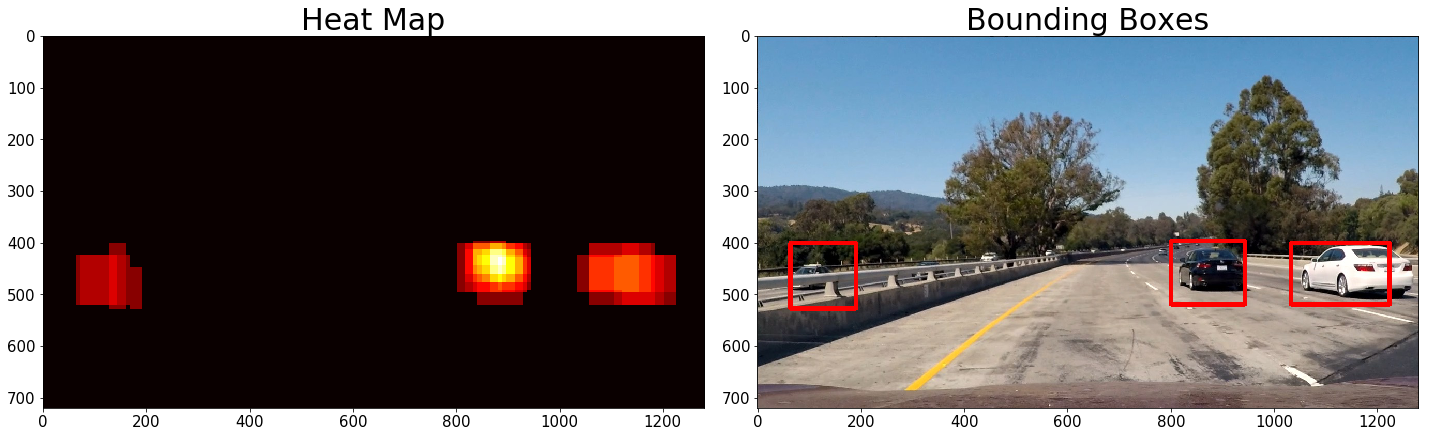

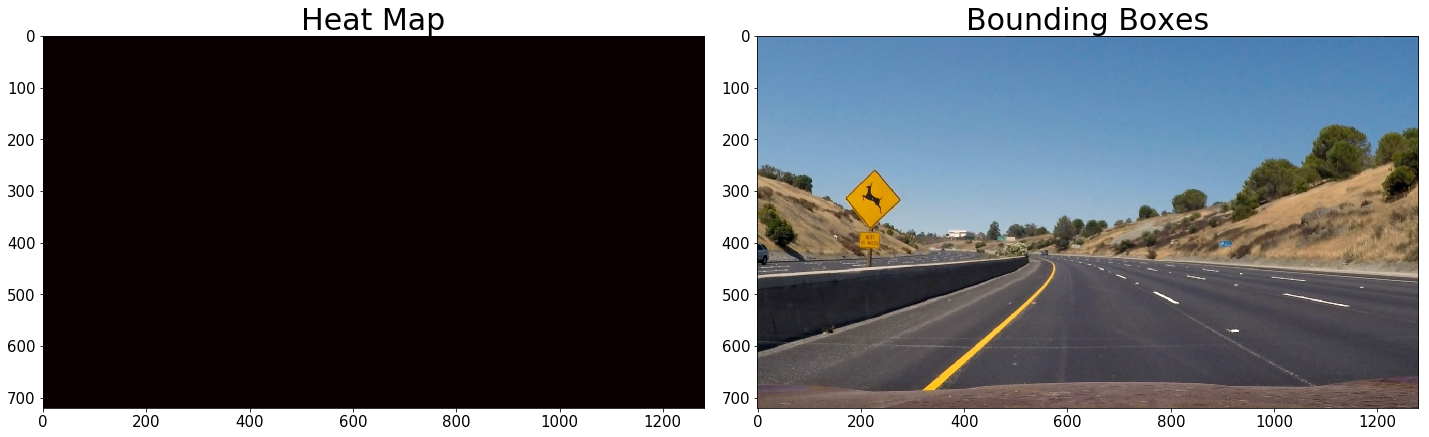

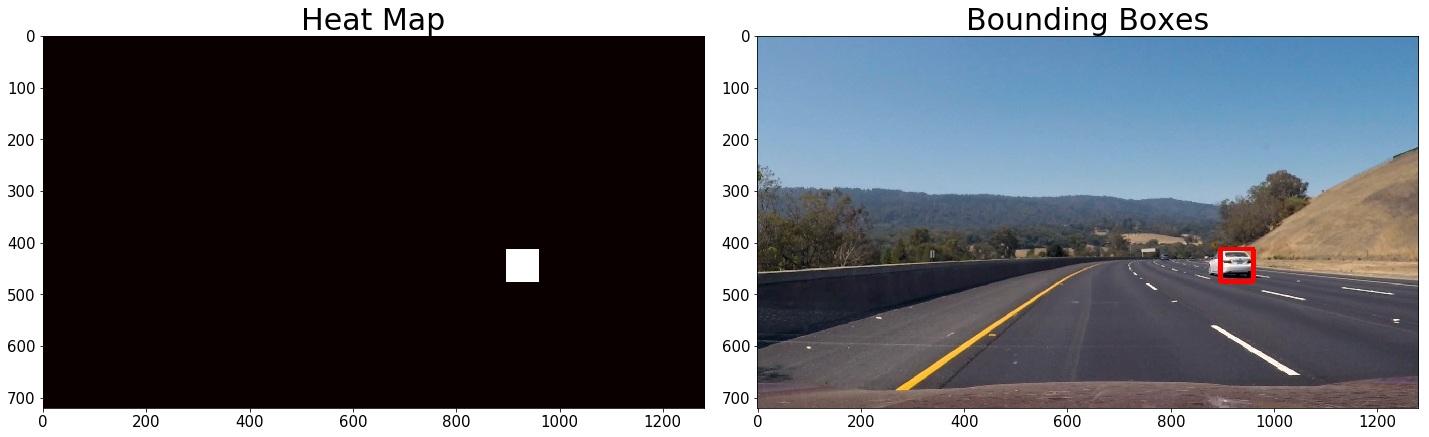

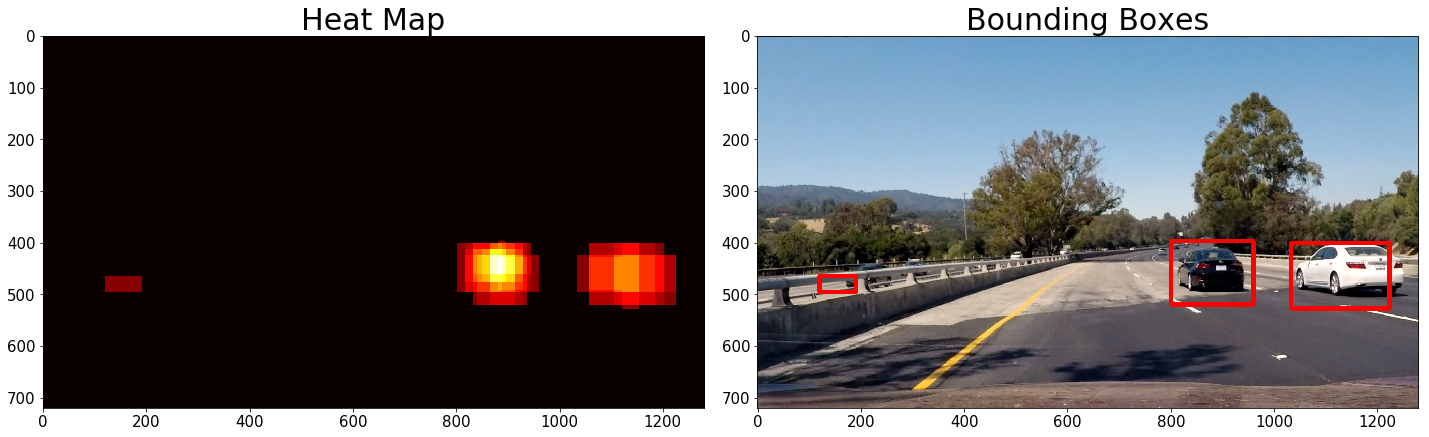

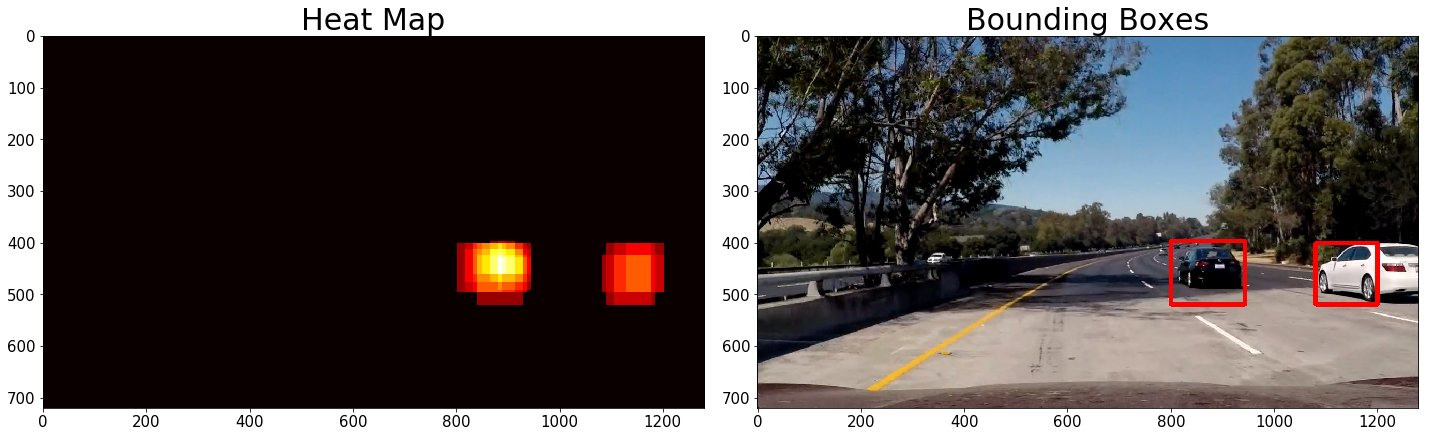

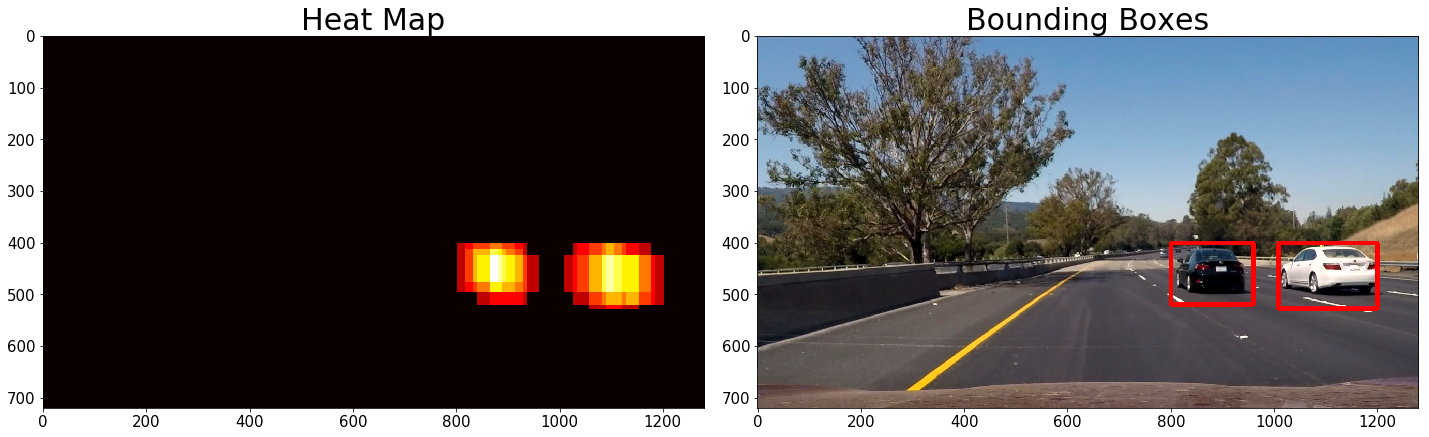

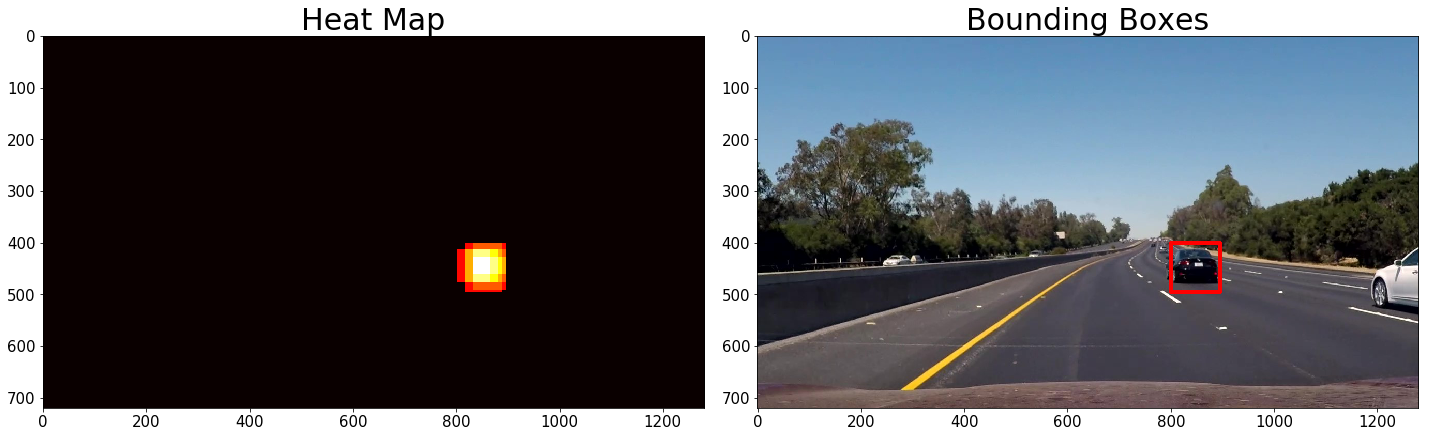

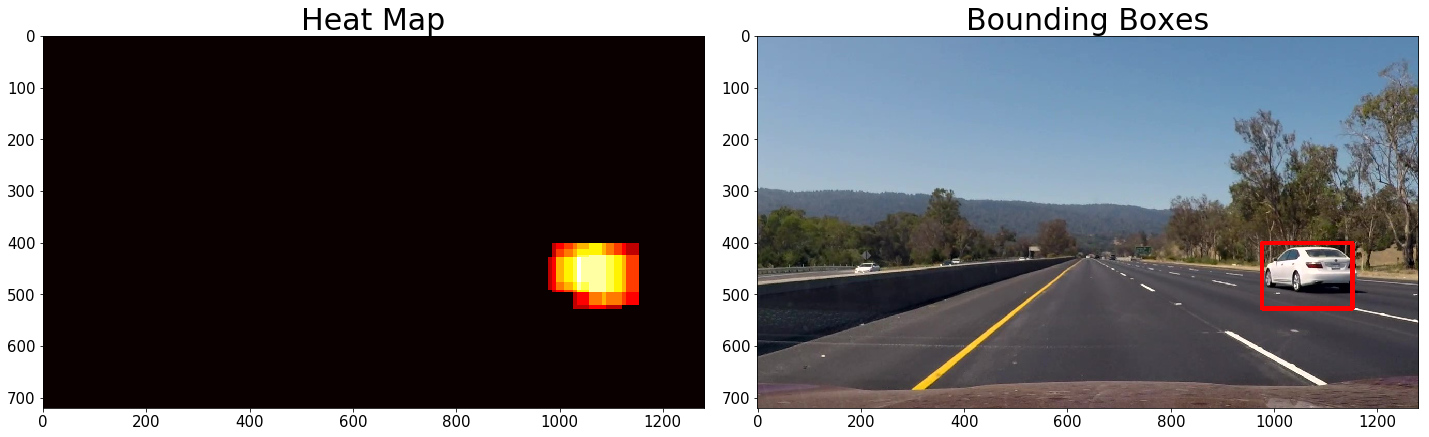

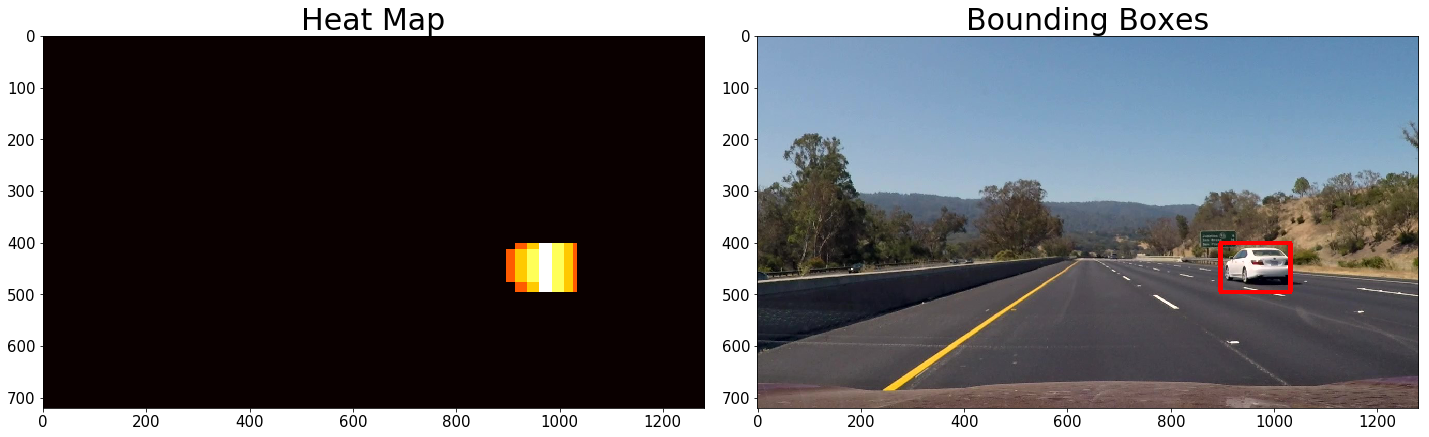

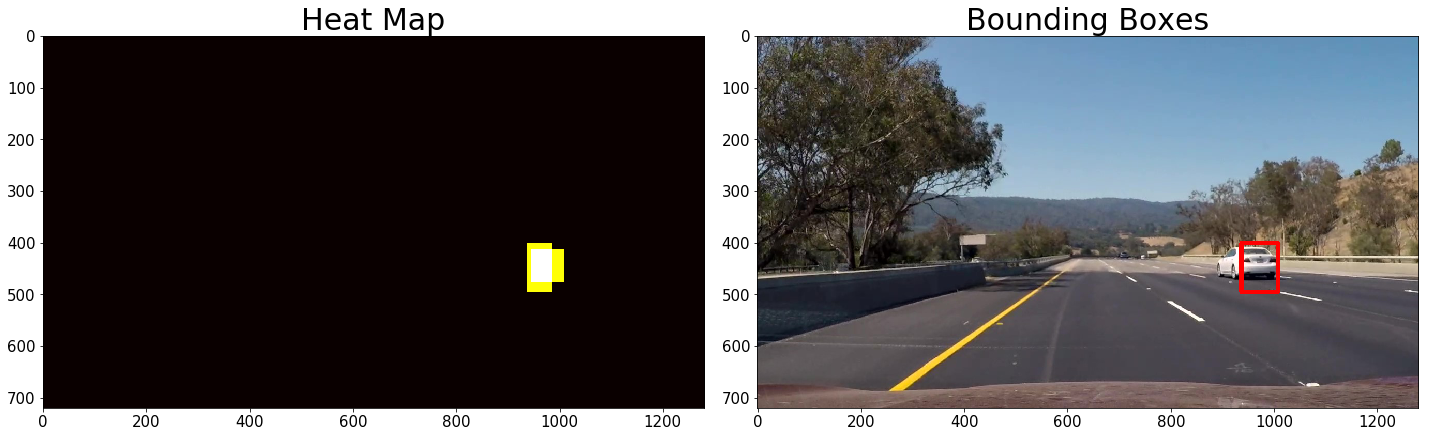

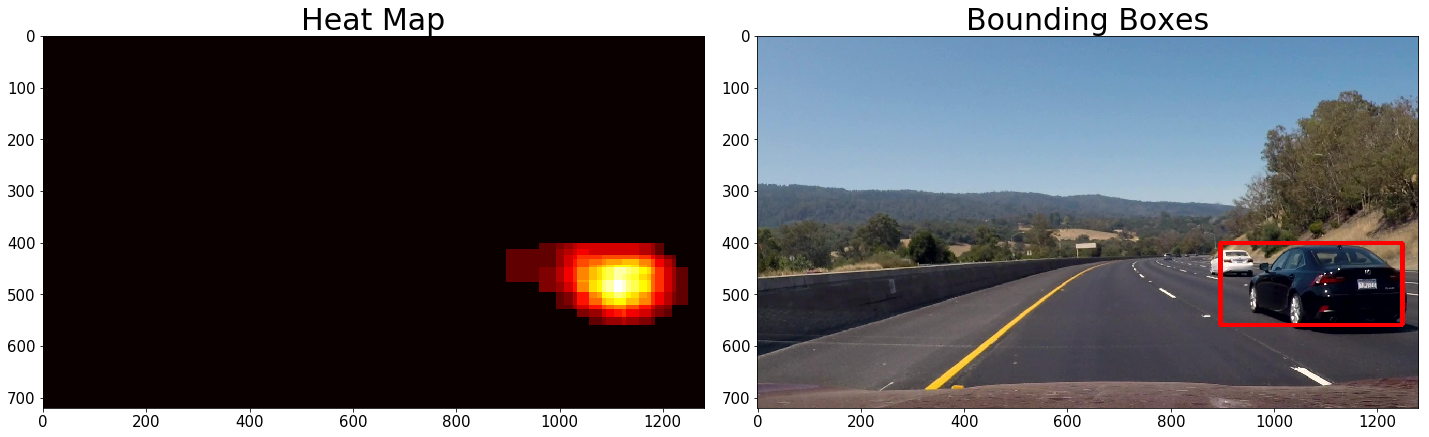

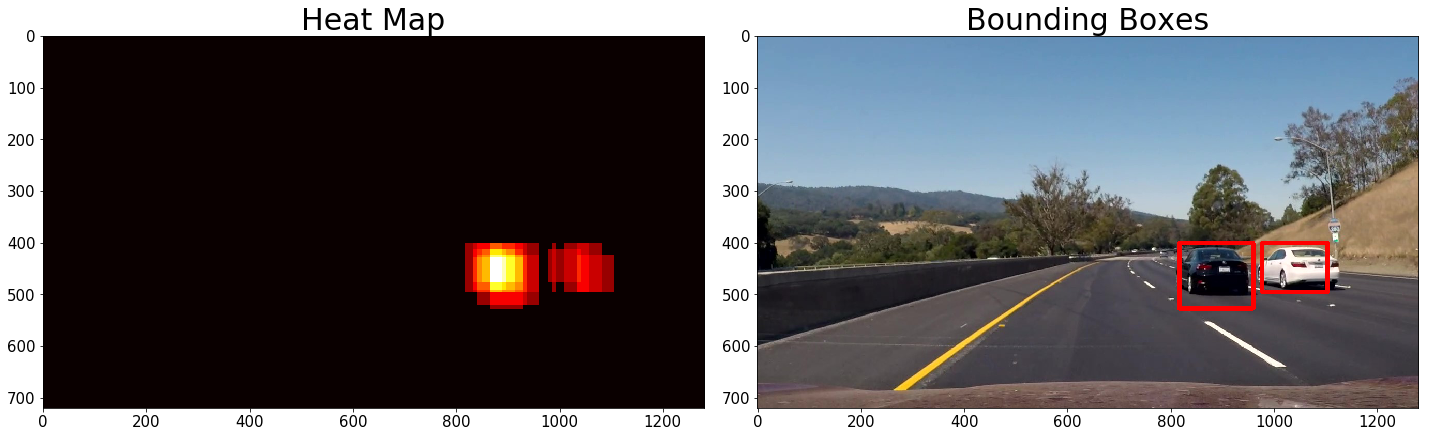

In [26]:
# Reading in the test images (some images manually added taken from project_video)

for i in range(1,13):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    # This scale searches for vehicles further away from the camera
    ystart = 380
    ystop = 540
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # This scale is used to detect vehicles at a medium distance from camera
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # This scale is used to detect vehicles close to the camera
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    # Got this brilliant method to read items in a list from GitHub 
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    
    #Applying a threshold of greater than 2 detections 
    heat = apply_threshold(heat, 2)  
    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    plt.tight_layout()
    ax1.imshow(heat, cmap='hot')
    ax1.set_title('Heat Map', fontsize=30)
    ax2.imshow(new_img)
    ax2.set_title('Bounding Boxes', fontsize=30)

In [27]:
def pipeline(img):

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    # This scale searches for vehicles further away from the camera
    ystart = 380
    ystop = 540
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))

    # This scale is used to detect vehicles at a medium distance from camera
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # This scale is used to detect vehicles close to the camera
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [29]:
test_output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(pipeline) #.subclip(4,15)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:28<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 27min 29s
